#Setting Up the Models

##Install Libraries and Import Packages

In [1]:
!pip install ucimlrepo optuna lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 17.5 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cf21d4ac9a6bc870718fd3f710a346da512fb3d744498068bf4d35b089e11c63
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import graphviz
from sklearn.tree import export_graphviz
from lime.lime_tabular import LimeTabularExplainer

#fetch dataset
heart_disease = fetch_ucirepo(id=45)

#data
df = heart_disease.data.original.copy()

##Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


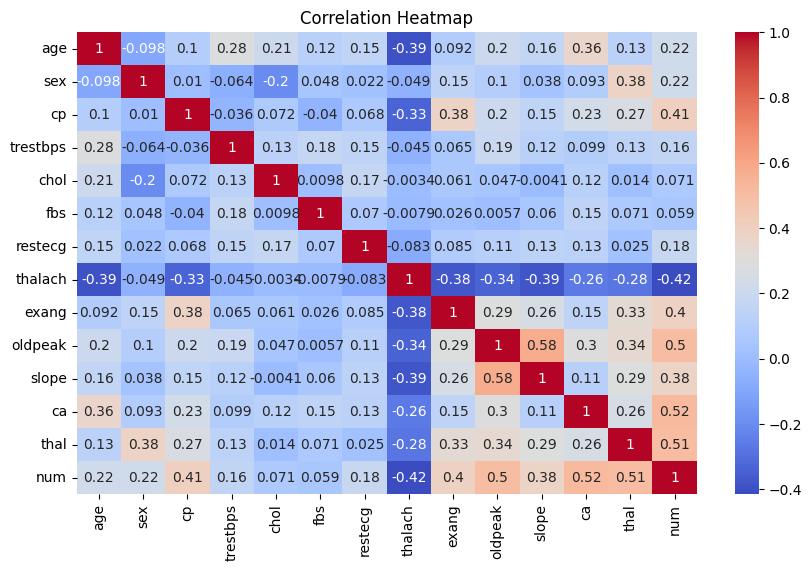

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

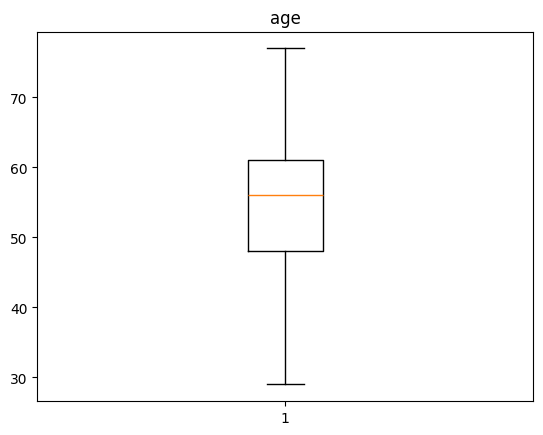

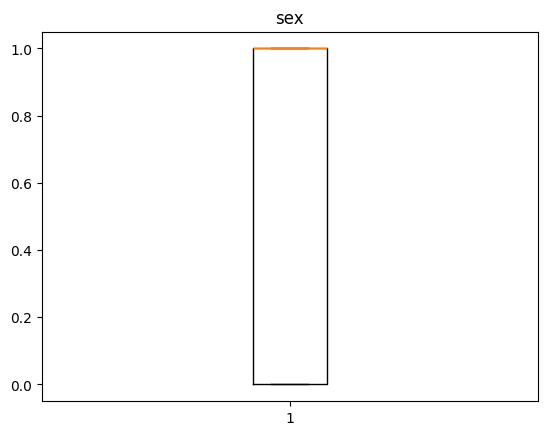

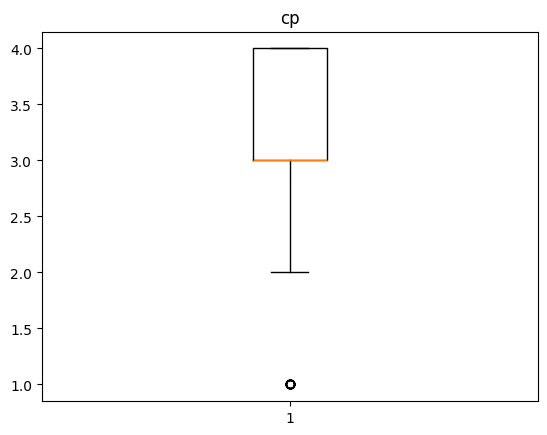

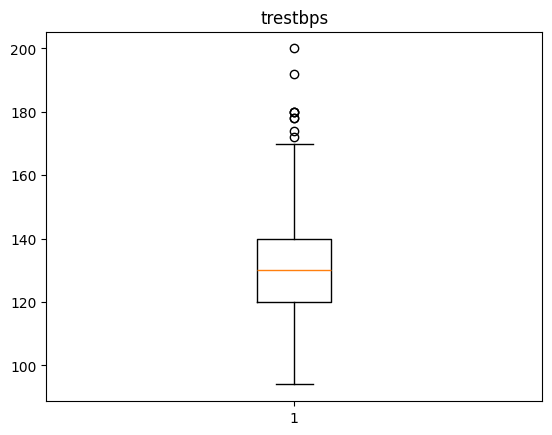

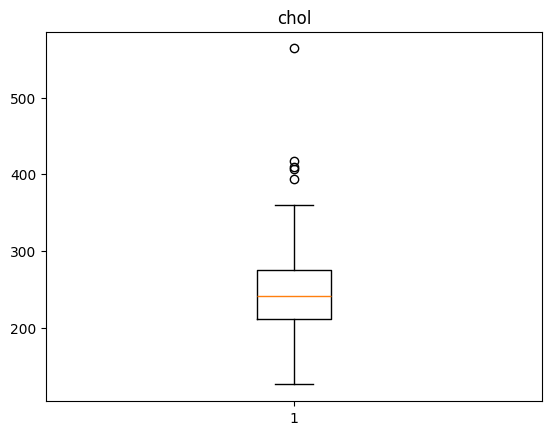

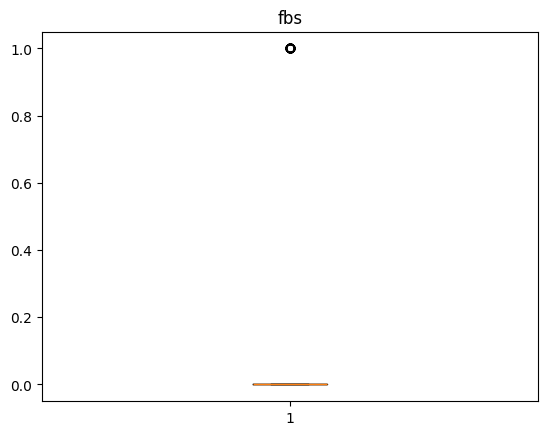

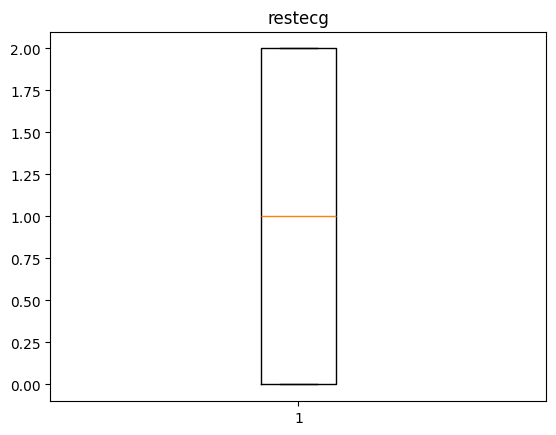

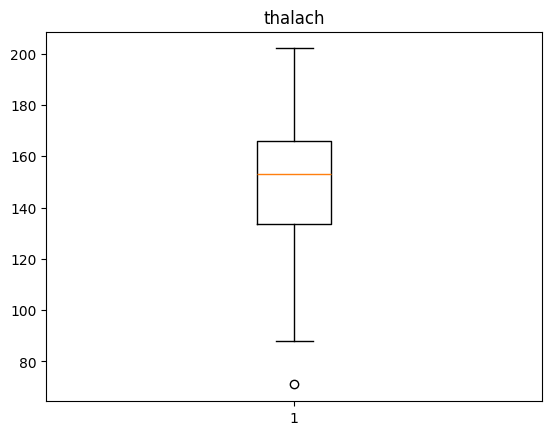

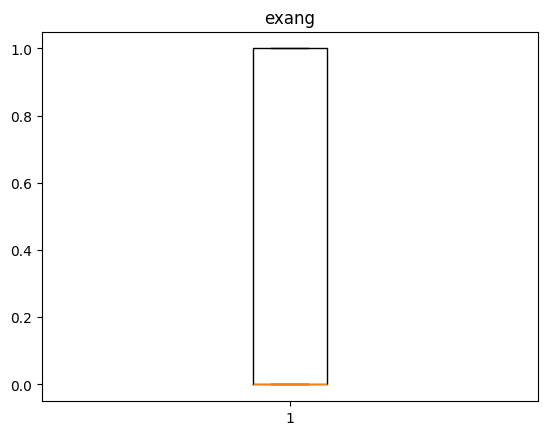

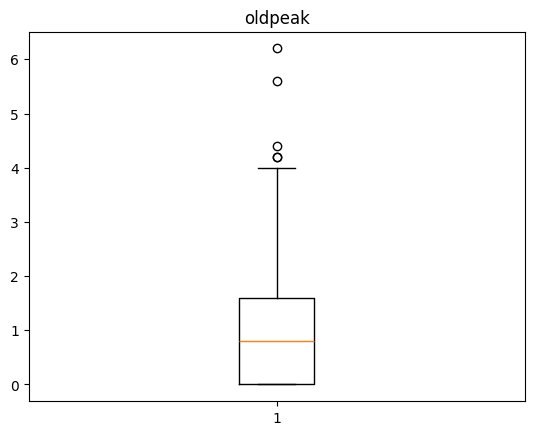

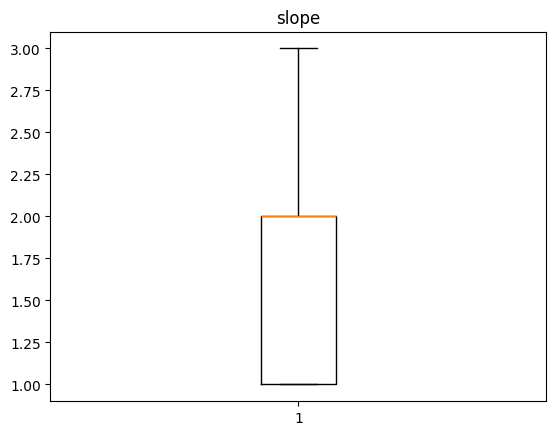

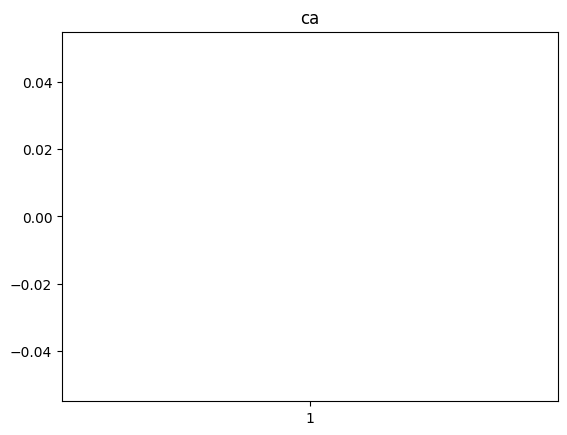

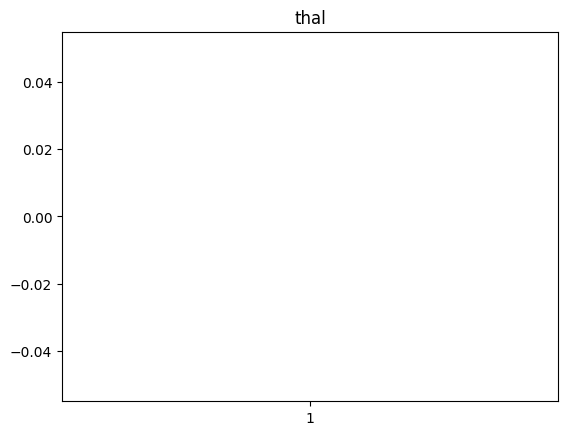

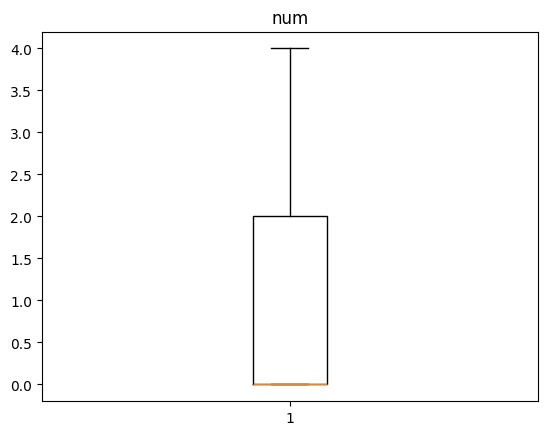

In [7]:
for col in df.columns:
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.isna().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


##Handling NaN Values with SimpleImputer

In [10]:
imputer = SimpleImputer(missing_values = np.nan, strategy ='mean')
imputer = imputer.fit(df)
df = imputer.transform(df)

#convert NP to DF
df = pd.DataFrame(df, columns=heart_disease.data.original.columns)

##Combining Classes

In [11]:
X = df.drop('num', axis=1)
y = df['num']

#for plot
feature_names = X.columns

#class 0 -> no disease(0) / classes 1-4 -> disease(1)
y_binary = y.copy()
y_binary[y_binary > 0] = 1

##Spliting and Scaling the Data

In [12]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.25, random_state=0, stratify=y_binary)

#scale
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##Creating the Optimized Models and Then Fitting them

In [13]:
#Decision Tree Model
dt = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                            max_depth=4, max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=16, min_samples_split=4,
                            min_weight_fraction_leaf=0.0, monotonic_cst=None, random_state=100, splitter='random')

#Logistic Regression Model
lr = LogisticRegression(C=0.010993634452683504, class_weight='balanced', dual=False,
                        fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100,
                        multi_class='deprecated', n_jobs=None, penalty='l2', random_state=100, solver='liblinear',
                        tol=0.0001, verbose=0, warm_start=False)

#Random Forest Model
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
                            max_depth=15, max_features='sqrt', max_leaf_nodes=None, max_samples=None,
                            min_impurity_decrease=0.0, min_samples_leaf=15, min_samples_split=16,
                            min_weight_fraction_leaf=0.0, monotonic_cst=None, n_estimators=53, n_jobs=None,
                            oob_score=False, random_state=100, verbose=0, warm_start=False)

#XGBoost Model
xgb = XGBClassifier(objective='binary:logistic', base_score=None, booster=None, callbacks=None,
                    colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.7504717399139913,
                    device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None,
                    feature_types=None, gamma=0.6497146261841261, grow_policy=None, importance_type=None,
                    interaction_constraints=None, learning_rate=0.021618964126433812, max_bin=None, max_cat_threshold=None,
                    max_cat_to_onehot=None, max_delta_step=None, max_depth=7, max_leaves=None, min_child_weight=None,
                    missing=np.nan, monotone_constraints=None, multi_strategy=None, n_estimators=347, n_jobs=None,
                    num_parallel_tree=None, random_state=100, reg_alpha=0.0010349590106072711, reg_lambda=0.02637083647277659,
                    sampling_method=None, scale_pos_weight=8.443990241900503, subsample=0.7040523480851058, tree_method=None,
                    validate_parameters=None, verbosity=None)

In [14]:
dt.fit(X_train, y_train)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7504717399139913, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.6497146261841261, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.021618964126433812,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=347, n_jobs=None,
              num_parallel_tree=None, ...)

##Evaluating Each Model's Performance

In [15]:
#For dt
dt_pred = dt.predict(X_test)
print("\nFor the Decision Tree Model:\nAccuracy: " + str(accuracy_score(y_test, dt_pred) * 100) + "%")
print("Classification Report:\n" + str(classification_report(y_test, dt_pred)))


For the Decision Tree Model:
Accuracy: 86.8421052631579%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89        41
         1.0       0.93      0.77      0.84        35

    accuracy                           0.87        76
   macro avg       0.88      0.86      0.87        76
weighted avg       0.88      0.87      0.87        76



In [16]:
#For lr
lr_pred = lr.predict(X_test)
print("\nFor the Logistic Regression Model:\nAccuracy: " + str(accuracy_score(y_test, lr_pred) * 100) + "%")
print("Classification Report:\n" + str(classification_report(y_test, lr_pred)))


For the Logistic Regression Model:
Accuracy: 88.1578947368421%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89        41
         1.0       0.88      0.86      0.87        35

    accuracy                           0.88        76
   macro avg       0.88      0.88      0.88        76
weighted avg       0.88      0.88      0.88        76



In [17]:
#For rf
rf_pred = rf.predict(X_test)
print("\nFor the Random Forest Model:\nAccuracy: " + str(accuracy_score(y_test, rf_pred) * 100) + "%")
print("Classification Report:\n" + str(classification_report(y_test, rf_pred)))


For the Random Forest Model:
Accuracy: 90.78947368421053%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92        41
         1.0       0.97      0.83      0.89        35

    accuracy                           0.91        76
   macro avg       0.92      0.90      0.91        76
weighted avg       0.91      0.91      0.91        76



In [18]:
#For xgb
xgb_pred = xgb.predict(X_test)
print("\nFor the XGBoost Model:\nAccuracy: " + str(accuracy_score(y_test, xgb_pred) * 100) + "%")
print("Classification Report:\n" + str(classification_report(y_test, xgb_pred)))


For the XGBoost Model:
Accuracy: 89.47368421052632%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        41
         1.0       0.89      0.89      0.89        35

    accuracy                           0.89        76
   macro avg       0.89      0.89      0.89        76
weighted avg       0.89      0.89      0.89        76



#Global Explainability

##Decision Tree's Tree Structure

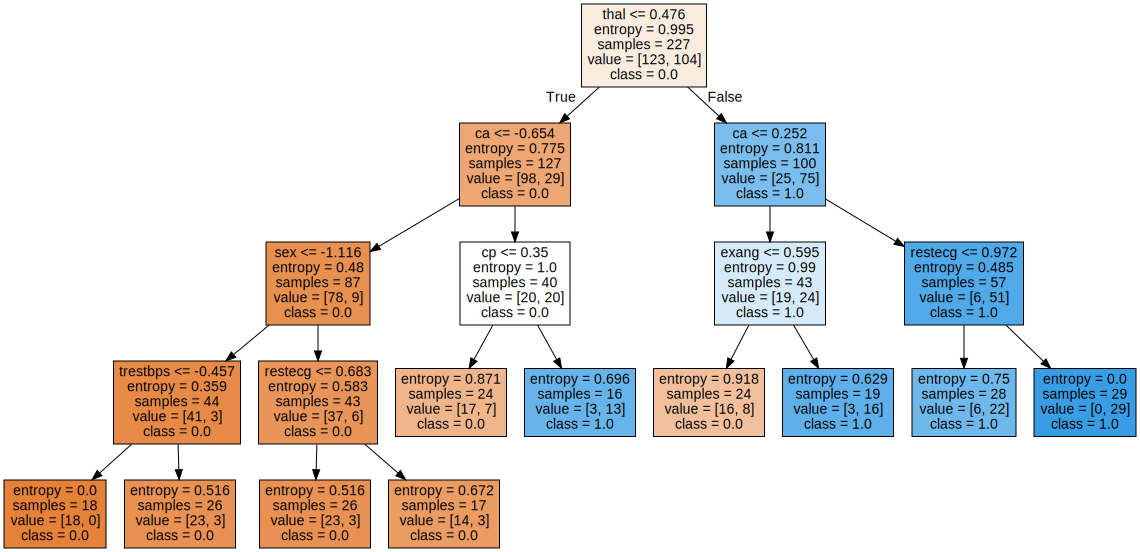

In [19]:
dot_data = export_graphviz(dt, out_file=None,
                                feature_names=feature_names,
                                class_names=[str(x) for x in y_binary.unique()],
                                filled=True)

graph = graphviz.Source(dot_data, format="png")
graph

##Logistic Regression Model's Coefficients

In [20]:
coefficients = pd.Series(lr.coef_[0], index=feature_names)
print("Logistic Regression Coefficients:\n")
print(coefficients.sort_values(ascending=False))

Logistic Regression Coefficients:

ca          0.262456
thal        0.261943
exang       0.186021
cp          0.172525
oldpeak     0.171246
sex         0.168589
slope       0.157803
age         0.092721
restecg     0.090458
trestbps    0.058925
chol        0.040020
fbs        -0.021021
thalach    -0.181376
dtype: float64


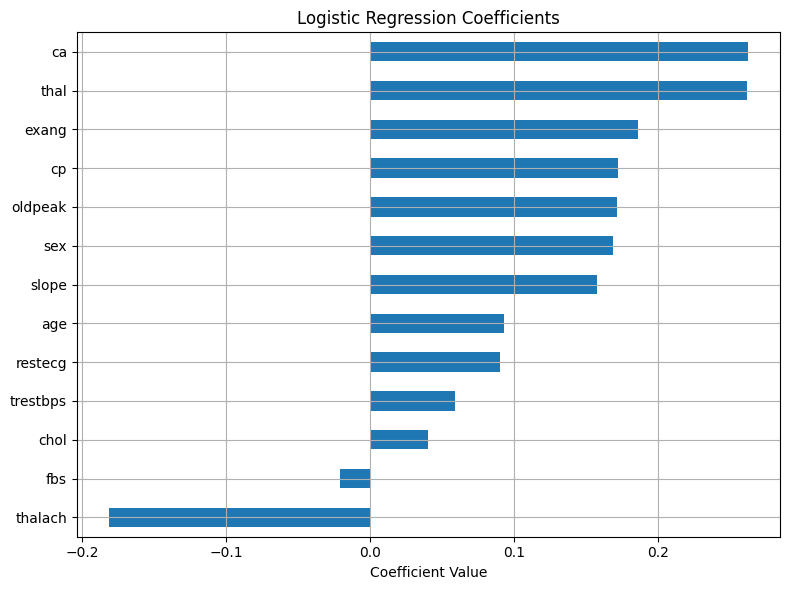

In [21]:
coefficients.sort_values().plot(kind="barh", figsize=(8, 6))
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.grid()
plt.show()

##Setting Up SHAP explainers

In [22]:
#turn data into DF for SHAP plots
X_test_df = pd.DataFrame(X_test, columns=feature_names)

#SHAP for dt
dt_explainer = shap.TreeExplainer(dt)
dt_shap_values = dt_explainer.shap_values(X_test_df)

#SHAP for lr
lr_explainer = shap.LinearExplainer(lr, masker=shap.maskers.Independent(X_test_df))
lr_shap_values = lr_explainer.shap_values(X_test_df)

#SHAP for rf
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(X_test_df)

#SHAP for xgb
xgb_explainer = shap.Explainer(xgb)
xgb_shap_values = xgb_explainer.shap_values(X_test_df)

##SHAP Summary Plots For Each Model

In [23]:
dt_shap_values.shape

(76, 13, 2)

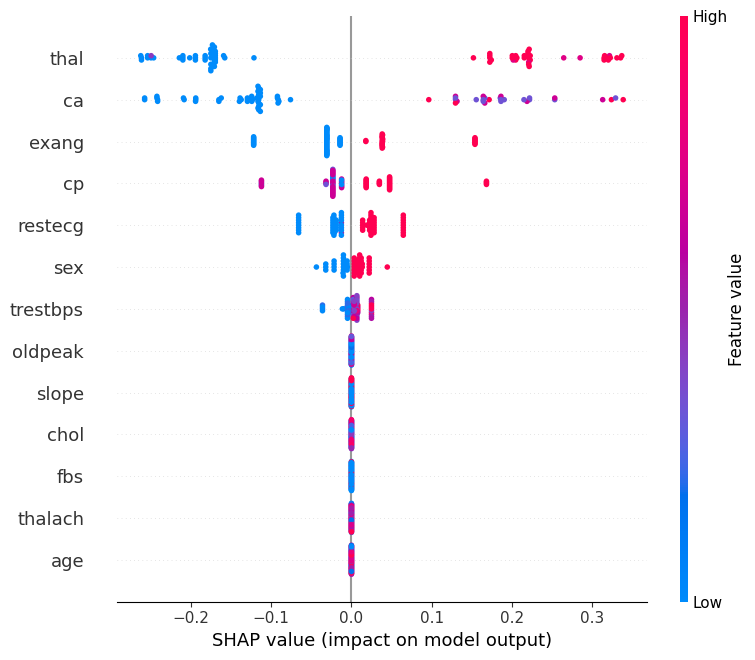

In [24]:
#dt
shap.summary_plot(dt_shap_values[:, :, 1], X_test_df)

In [25]:
lr_shap_values.shape

(76, 13)

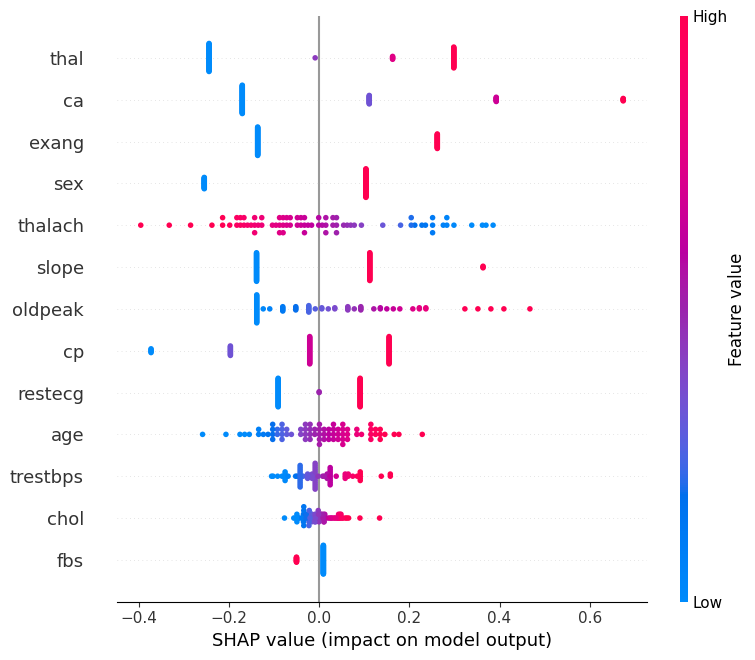

In [26]:
#lr
shap.summary_plot(lr_shap_values, X_test_df)

In [27]:
rf_shap_values.shape

(76, 13, 2)

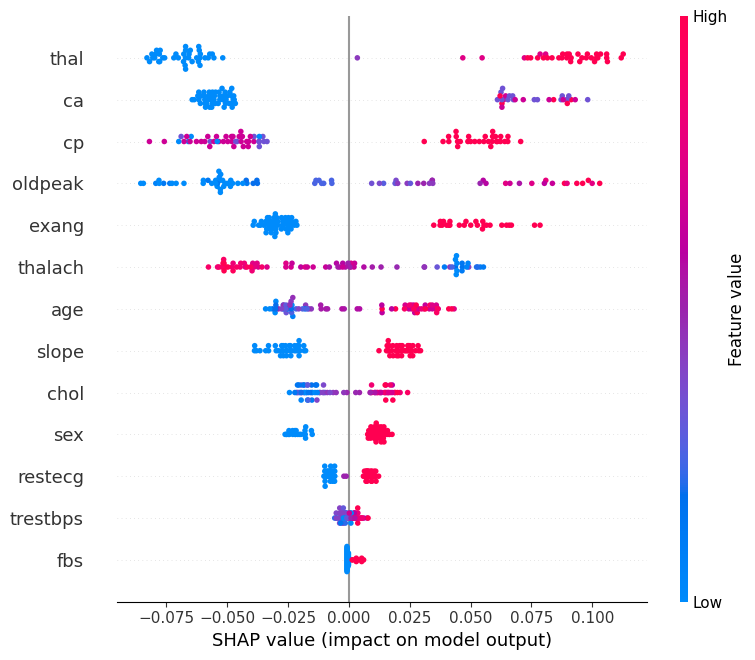

In [28]:
#rf
shap.summary_plot(rf_shap_values[:, :, 1], X_test_df)

In [29]:
xgb_shap_values.shape

(76, 13)

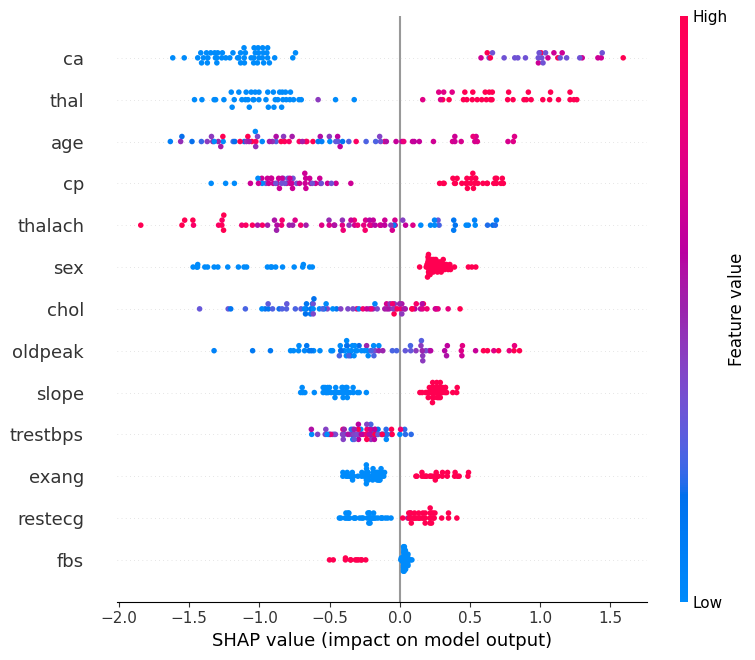

In [30]:
#xgb
shap.summary_plot(xgb_shap_values, X_test_df)

#Local Explainability

##Selecting Instance

In [31]:
index = 0

##Decision Path

In [32]:
X_instance = X_test[index].reshape(1, -1)

node_indicator = dt.decision_path(X_instance)
leaf_id = dt.apply(X_instance)

print(f"\nDecision path for instance {index}:")
for node_id in node_indicator.indices:
    if dt.tree_.children_left[node_id] != dt.tree_.children_right[node_id]:
        feature = feature_names[dt.tree_.feature[node_id]]
        threshold = dt.tree_.threshold[node_id]
        if X_instance[0, dt.tree_.feature[node_id]] <= threshold:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        print(f"  {feature} = {X_instance[0, dt.tree_.feature[node_id]]:.2f} "
              f"{threshold_sign} {threshold:.2f}")

pred_class = dt.predict(X_instance)[0]
true_class = y_test.iloc[index] if isinstance(y_test, pd.Series) else y_test[index]

print(f"\nPredicted class: {pred_class}")
print(f"Actual class:    {true_class}")


Decision path for instance 0:
  thal = 0.67 > 0.48
  ca = -0.75 <= 0.25
  exang = -0.69 <= 0.60

Predicted class: 0.0
Actual class:    0.0


##Logistic Regression's Contributions For Single Instance

In [33]:
contributions = X_test_df.iloc[index] * lr.coef_[0]
print(contributions.sort_values(ascending=False))

thal        0.174666
cp          0.145704
sex         0.118423
slope       0.096235
trestbps    0.028758
age         0.024793
fbs         0.008670
thalach     0.006674
chol       -0.043102
restecg    -0.089666
oldpeak    -0.096123
exang      -0.128075
ca         -0.195577
Name: 0, dtype: float64


##SHAP Waterfalls

In [43]:
#dt
shap.initjs()
shap.force_plot(dt_explainer.expected_value[1], dt_shap_values[index, :, 1], X_test_df.iloc[index])

In [35]:
#lr
shap.initjs()
shap.force_plot(lr_explainer.expected_value, lr_shap_values[index, :], X_test_df.iloc[index])

In [36]:
#rf
shap.initjs()
shap.force_plot(rf_explainer.expected_value[1], rf_shap_values[index, :, 1], X_test_df.iloc[index])

In [37]:
#xgb
shap.initjs()
shap.force_plot(xgb_explainer.expected_value, xgb_shap_values[index, :], X_test_df.iloc[index])

##Setting up LIME Explainer

In [38]:
explainer = LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['No Disease', 'Disease'], mode='classification')

##LIME Explanations for Each Model

In [39]:
#dt
dt_lime = explainer.explain_instance(X_test[index], dt.predict_proba, num_features=len(feature_names))
dt_lime.as_list()

[('exang <= -0.69', -0.16462581173075444),
 ('-0.69 < cp <= 0.84', 0.14375420407763495),
 ('ca <= -0.75', -0.10394255452075431),
 ('-0.89 < thal <= 1.18', 0.10338363926767083),
 ('-0.08 < trestbps <= 0.49', 0.01518681637523952),
 ('-0.71 < thalach <= 0.14', 0.014742776756552415),
 ('0.16 < age <= 0.71', 0.010383431294168763),
 ('-0.98 < slope <= 0.61', -0.00575661085826021),
 ('fbs <= -0.41', 0.005057083210142676),
 ('-0.90 < oldpeak <= -0.22', -0.004925643579365016),
 ('restecg <= -0.99', 0.003887891045357077),
 ('chol <= -0.70', 0.002880018946205431),
 ('-1.42 < sex <= 0.70', -0.00045660386219462725)]

In [40]:
#lr
lr_lime = explainer.explain_instance(X_test[index], lr.predict_proba, num_features=len(feature_names))
lr_lime.as_list()

[('-0.69 < cp <= 0.84', 0.07327150334717342),
 ('exang <= -0.69', -0.06002251090760551),
 ('-0.89 < thal <= 1.18', 0.05897640494994957),
 ('ca <= -0.75', -0.052107446142502546),
 ('-0.90 < oldpeak <= -0.22', -0.044267967823069986),
 ('-1.42 < sex <= 0.70', 0.030904278514407427),
 ('restecg <= -0.99', -0.02277189427699952),
 ('chol <= -0.70', -0.017943051860273344),
 ('0.16 < age <= 0.71', 0.015676539370640147),
 ('fbs <= -0.41', 0.012871134365047195),
 ('-0.71 < thalach <= 0.14', 0.012491694797110108),
 ('-0.98 < slope <= 0.61', 0.011095945662017685),
 ('-0.08 < trestbps <= 0.49', 0.004506669993840452)]

In [41]:
#rf
rf_lime = explainer.explain_instance(X_test[index], rf.predict_proba, num_features=len(feature_names))
rf_lime.as_list()

[('-0.89 < thal <= 1.18', 0.09555162591979395),
 ('-0.90 < oldpeak <= -0.22', -0.09173041170305878),
 ('ca <= -0.75', -0.0845917444262571),
 ('exang <= -0.69', -0.0741991397033692),
 ('-0.69 < cp <= 0.84', 0.07162150558241884),
 ('0.16 < age <= 0.71', 0.03920606586301267),
 ('-0.71 < thalach <= 0.14', 0.03136499095273882),
 ('chol <= -0.70', -0.01582255490336985),
 ('restecg <= -0.99', -0.004587295070100359),
 ('fbs <= -0.41', -0.0035066296092614415),
 ('-0.98 < slope <= 0.61', 0.0034647534528163596),
 ('-1.42 < sex <= 0.70', 0.0033858480852001836),
 ('-0.08 < trestbps <= 0.49', 0.00043462840079545824)]

In [42]:
#xgb
xgb_lime = explainer.explain_instance(X_test[index], xgb.predict_proba, num_features=len(feature_names))
xgb_lime.as_list()

[('0.16 < age <= 0.71', 0.2291744730615453),
 ('-0.89 < thal <= 1.18', 0.22699439599193574),
 ('-1.42 < sex <= 0.70', 0.21751317132445366),
 ('ca <= -0.75', -0.14091978423009963),
 ('-0.90 < oldpeak <= -0.22', -0.10052192776367488),
 ('-0.98 < slope <= 0.61', 0.08838109180284535),
 ('fbs <= -0.41', 0.07760356817240015),
 ('chol <= -0.70', -0.0719660574581309),
 ('exang <= -0.69', -0.07080311277186715),
 ('restecg <= -0.99', -0.059896896075615096),
 ('-0.71 < thalach <= 0.14', -0.032068714710370656),
 ('-0.08 < trestbps <= 0.49', 0.020480744058349265),
 ('-0.69 < cp <= 0.84', 0.012996599061908384)]